# gör predict på aktier, crypto mm samt back testing

In [560]:
import yfinance as yf
import ta
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [561]:
df = pd.DataFrame()
ticker = "ETH-USD"
# ticker = "TSLA-USD"

if os.path.exists(ticker+".csv"):
    print('använd sparad fil')
    df = pd.read_csv(ticker+".csv", index_col=0)
else:
    df = yf.download(ticker,period='max')  #  tex: start="2019-01-01", end="2020-01-01")
    df.to_csv(ticker+".csv")
    
df.index = pd.to_datetime(df.index)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2022-09-02,1586.017944,1643.183228,1551.877930,1577.220459,1577.220459,17708478709
2022-09-03,1577.213745,1579.454346,1541.672119,1556.872681,1556.872681,9516825994
2022-09-04,1556.895874,1578.009277,1543.698853,1577.641602,1577.641602,8884144998


<AxesSubplot:xlabel='Date'>

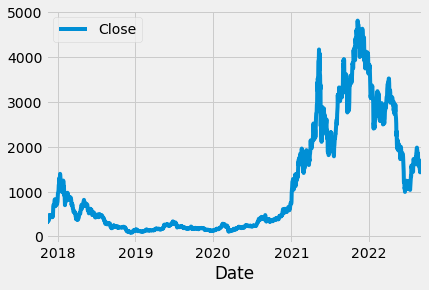

In [562]:
df.plot.line(y="Close") #, use_index=True)

In [563]:
from ta.volatility import BollingerBands
    
def add_bolinger_bands(df):
    # df.dropna(inplace=True)

    # Initialize Bollinger Bands Indicator
    indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2)

    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()

    # Add Bollinger Band high indicator
    df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

    # Add Bollinger Band low indicator
    df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

    df['Sell'] = ((df['Close'] > df['bb_bbh']) & (df['stoch_k'] > 0.95))*1
    df['Buy'] = ((df['Close'] < df['bb_bbl']) & (df['stoch_k'] < 0.05))*1

    df.dropna(inplace=True)


In [564]:
def indicators(df, bollinger=True):
    df['SMA_180'] = ta.trend.sma_indicator(df['Close'], window=180)
    df['stoch_k'] = ta.momentum.stochrsi_k(df['Close'], window=10)
 
    # Target    
    df['Tomorrow'] = df['Close'].shift(-1)   # alltså nästa dag
    df['y'] = (df['Tomorrow'] > df['Close']).astype(int)
    df.dropna(inplace=True)
    predictors = ['Open','High', 'Low', 'Close', 'Volume', 'SMA_180', 'stoch_k']
    if bollinger:
        add_bolinger_bands(df)
        predictors += ['bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi', 'bb_bbli', 'Sell', 'Buy']
    return predictors
        

In [565]:
predictors=indicators(df, bollinger = True)

df.head(3)

,Open,High,Low,Close,Adj Close,Volume,SMA_180,stoch_k,Tomorrow,y,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,Sell,Buy
Date,,,,,,,,,,,,,,,,,
2018-05-26,587.426025,606.174988,583.512024,587.280029,587.280029,1694300032,739.651973,0.146584,572.668030,0,685.848700,795.799140,575.898260,0.0,0.0,0,0
2018-05-27,588.520020,590.328003,562.866028,572.668030,572.668030,1788790016,740.206229,0.090979,516.036011,0,676.795853,792.562075,561.029630,0.0,0.0,0,0
2018-05-28,573.044983,576.049011,512.552002,516.036011,516.036011,2356900096,740.697968,0.052232,565.388000,1,664.954803,794.772608,535.136999,0.0,1.0,0,0


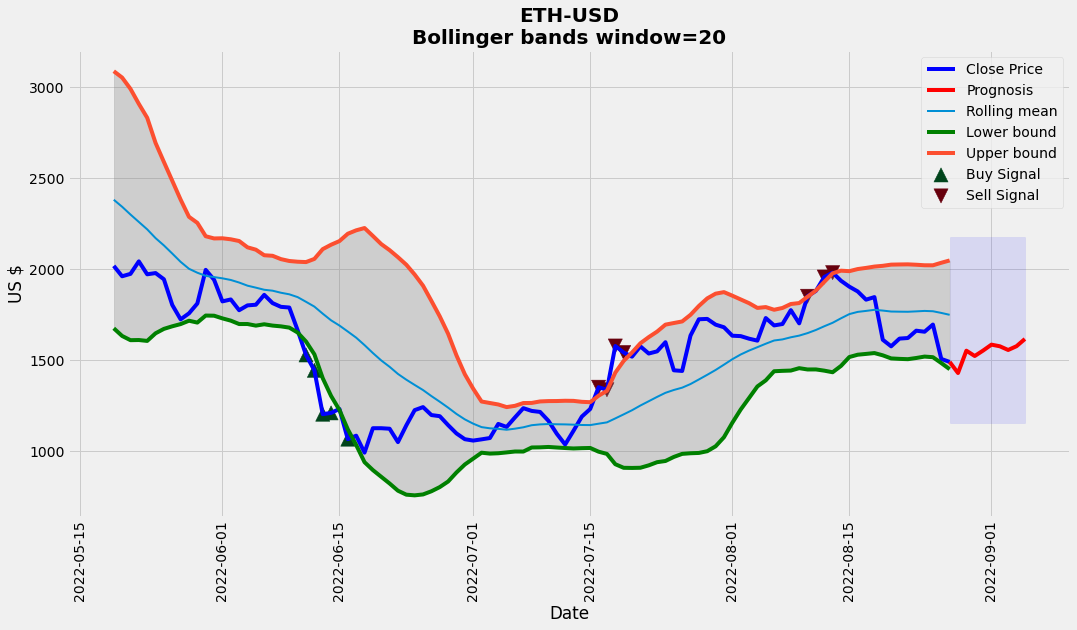

In [566]:
# Plot exempel matplotlib

import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

###############################################
### jag fejkar här att det finns en prognos ###
###############################################
antal_ticks = 100 # number of ticks to plot
antal_prognos = 10 # number of ticks predicted
df_prognos = df[-antal_prognos:] # get fejkade prognos ticks
# get the last antal_ticks before that (the real ticks)
df_ticks = df[-(antal_ticks+antal_prognos):-antal_prognos+1]
########### fejk end ###########################

### define plot area width=16 height=8 ###
fig, ax = plt.subplots(figsize=(16,8))

### create the plot to be modified ###
ax.plot(df_ticks['Close'], label='Close Price', linewidth=4, color='blue')    
ax.plot(df_prognos['Close'], label='Prognosis', linewidth=4, color='red') 

#### now modify the plot before showing it

### sätta egna ticks möjligt men inte nödvändigt då plt sköter det bättre själv ###
# ticks = df.index.values[::90]     
# tick_labels=[tick.year for tick in ticks]
# plt.xticks(ticks, rotation=90)
# ax.set_xticklabels(tick_labels)

ax.plot(df_ticks['bb_bbm'], label='Rolling mean', linewidth=2)   # plot another line in the same fig
ax.plot(df_ticks['bb_bbl'], label='Lower bound', linewidth=4, color='g')   # plot another line in the same fig
# plot another line in the same fig
ax.plot(df_ticks['bb_bbh'], label='Upper bound', linewidth=4)

### add buy /sell signals ###
df_Buy  = df_ticks.query('Close < bb_bbl')
df_Sell = df_ticks.query('Close > bb_bbh')
ax.scatter(df_Buy.index, df_Buy['Close'], s = 200, c=df_Buy['bb_bbli'], cmap='Greens_r', 
            label='Buy Signal', marker='^', alpha=1)
ax.scatter(df_Sell.index, df_Sell['Close'], s= 200, c=df_Sell['bb_bbhi'], cmap='Reds_r',
            label='Sell Signal', marker='v', alpha=1)

plt.xticks(rotation=90)

### super title ###
# plt.suptitle('ETH-USD Bollinger bands',fontsize=20, fontweight='bold')

### title ###
plt.title('ETH-USD\nBollinger bands window=20',fontsize=20,fontweight='bold')

### grey bollinger area between bands ###
ax.fill_between(df_ticks.index, df_ticks['bb_bbl'], df_ticks['bb_bbh'], color='grey', alpha=0.3)

### highlight the prognosis are ###
#ax.fill_between(df_prognos.index, df_prognos['bb_bbl'], df_prognos['bb_bbh'], color='blue', alpha=0.3)
ax.axvspan(xmin=df_prognos.index[0], xmax=df_prognos.index[-1], ymin=0.2, ymax=0.6,color='blue', alpha=0.1)
ax.set_xlabel("Date")
ax.set_ylabel("US $")
ax.legend()   # parametrar tex. (loc='upper left', fontsize=16)
plt.show()

## Start with ML

In [567]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier     
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


In [568]:
# df.index = pd.to_datetime(df.index)

In [569]:
df.y.value_counts()

1    805
0    759
Name: y, dtype: int64

In [570]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=2022)

train = df.iloc[:-100]
test = df.iloc[-100:]

rf.fit(train[predictors], train["y"])


RandomForestClassifier(min_samples_split=10, random_state=2022)

<AxesSubplot:title={'center':'Predictions vs true values (y)'}, xlabel='Date'>

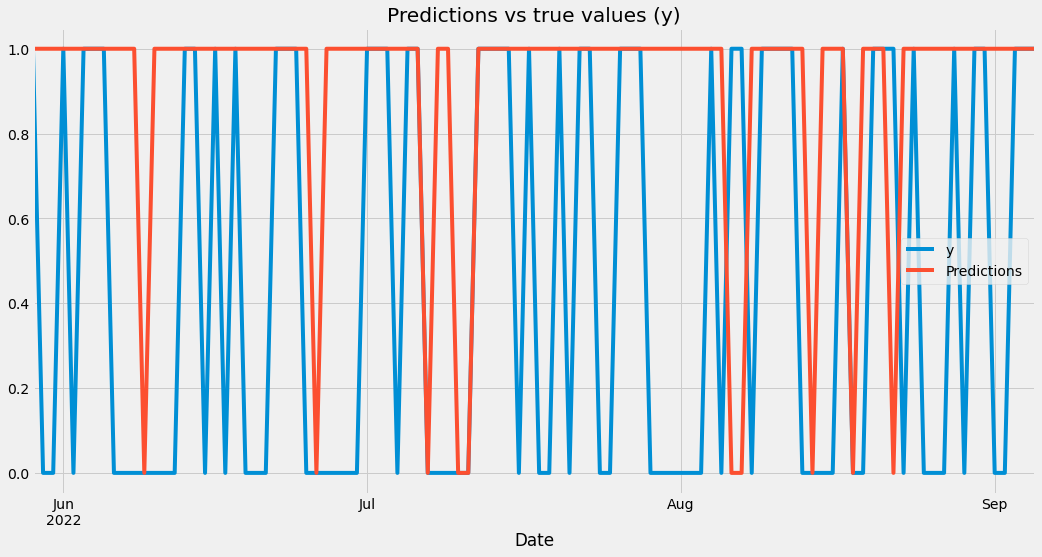

In [571]:

def predict(train, test, predictors, model, proba_val=None):
    model.fit(train[predictors], train["y"])
    
    if proba_val: # använd proba
        preds = model.predict_proba(test[predictors])[:,1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])
        
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["y"], preds], axis=1)
    # print(f'precision: {precision_score(test["y"],preds)}, ant_preds: {preds.sum()} av {test.shape[0]} Base: {test.y.sum()/test.shape[0]}')
    
    return combined

combined=predict(train, test, predictors, rf, proba_val=None)
combined.plot( figsize=(16, 8), title="Predictions vs true values (y)")
    


In [572]:
def backtest(data, model, predictors, proba_val=None, start=180, step=60):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


In [573]:
# # cross validation funkar inte bra med timeseries
# scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='precision')
# scores.mean()
predictions = backtest(df, rf, predictors)

predictions.query('y==Predictions and y==1').shape[0]
predictions["Predictions"].value_counts()
first_try = precision_score(predictions["y"], predictions["Predictions"])
predictions["y"].value_counts() / predictions.shape[0]


1    0.526012
0    0.473988
Name: y, dtype: float64

In [574]:
# tidsintervall i dagar för backtesting
horizons = [2, 5, 60, 250]  # skulle helst ha med upp till 4 år men ETH har för få värden
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["y"]

    new_predictors += [ratio_column, trend_column]
    
df = df.dropna()

df.head(1)


,Open,High,Low,Close,Adj Close,Volume,SMA_180,stoch_k,Tomorrow,y,...,Sell,Buy,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,108.900772,110.458359,106.525352,107.061012,107.061012,2828796031,189.339952,0.315066,107.609787,1,...,0,0,0.99145,1.0,0.988446,1.0,0.902538,30.0,0.390674,111.0


In [575]:
# Förbättrad backtestning
rf = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

predictions = backtest(df, rf, new_predictors, proba_val=0.6)
# display('Predictions value_counts:', predictions["Predictions"].value_counts())

print("New precision_score:\t", round(precision_score(predictions["y"], predictions["Predictions"]),4), '\nFirst_try:\t\t', round(first_try,4))

# print(f'{predictions["y"].value_counts() / predictions.shape[0]}')


New precision_score:	 0.5682 
First_try:		 0.5301


In [576]:
predictions.Predictions = predictions.Predictions.astype(int)
predictions.value_counts()

y  Predictions
1  0              422
0  0              404
1  1              175
0  1              133
dtype: int64

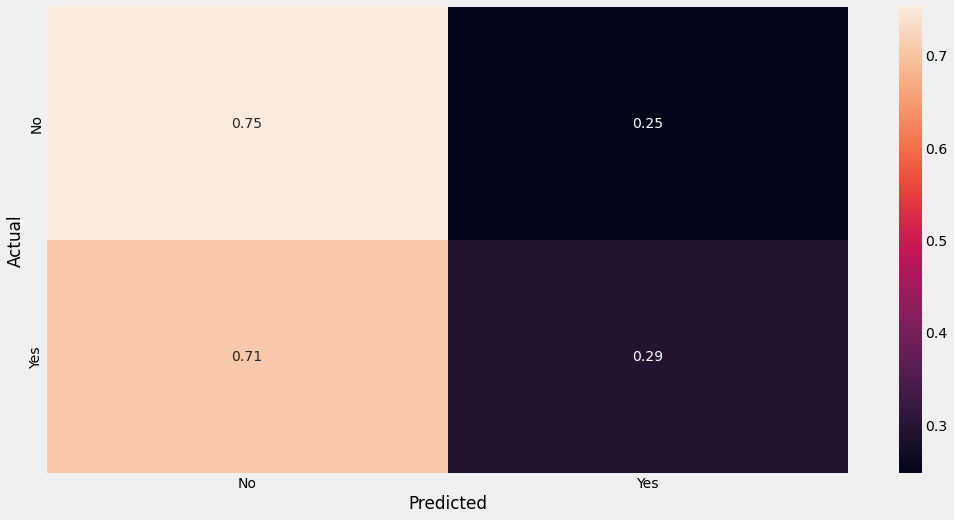

In [577]:
import seaborn as sns

def confusion(y_true, y_pred, labels=['Sell', 'Buy']):
    # plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm/cm.sum(axis=1)[:, np.newaxis]
    # make heatmap bigger
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    

confusion(predictions["y"], predictions["Predictions"])


In [535]:
new_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250']